In [1]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.metrics import mean_squared_error;

2.3.0


In [2]:
from constants import *;
from NN_predict_v1 import *;

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

### The goal of this file:
Try to set up the environment so that all the zip codes are fed into the data

#### Reading the zri csv file

In [4]:
multi_data = pd.read_csv('../data/zri_multifamily_v2.csv');
# multi_data = multi_data[multi_data["State"] == "NY"];
multi_data.head()

zip      City State        Metro      CountyName year-month    zri
0  1013  Chicopee    MA  Springfield  Hampden County    2014-01  928.0
1  1013  Chicopee    MA  Springfield  Hampden County    2014-02  931.0
2  1013  Chicopee    MA  Springfield  Hampden County    2014-03  934.0
3  1013  Chicopee    MA  Springfield  Hampden County    2014-04  929.0
4  1013  Chicopee    MA  Springfield  Hampden County    2014-05  929.0

In [5]:
# df = multi_data[multi_data["year-month"]=="2014-01"];
# temp = df.groupby("State")["zip"].count();
# temp = pd.DataFrame({"State": temp.index, "num_zip": temp});
# temp.reset_index(drop = True, inplace = True);

In [6]:
# temp.sort_values("num_zip", ascending = False, inplace = True);
# print(df[df["State"].isin(zone_dict["zone_6"])].shape[0])

zone_dict = {
    "zone_1": ["MA", "CT", "RI", "DC", "NJ", "ME", "NH"],
    "zone_2": ["NY"],
    "zone_3": ["FL", "GA", "NC", "TN", "SC", "KY", "MO", "AR"],
    "zone_4": ["CA", "WA", "OR", "AK", "HI"],
    "zone_5": ["TX", "CO", "AZ", "KS", "UT", "NV", "MT", "OK", "ND", "NM"],
    "zone_6": ["IL", "PA", "VA", "OH", "WI", "MD", "MN", "IN", "MI", "WV", "IA"]
};

In [7]:
# In our first try, just look at the zip codes in NY.
multi_1 = multi_data[multi_data["State"].isin(zone_dict["zone_1"])]["zip"].unique();
print(len(multi_1))

214


#### Segmenting the csv file into tens of thousands of windows

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
# test_NY = multi_data[multi_data["zip"] == 10001];

# single_city_series = np.array(test_NY["zri"])

In [10]:
cities_stats = {};
dataset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);
validset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);

dataset_created = False;
#for zip_num in multi_data["zip"].unique():
for zip_num in multi_1:
    test = multi_data[multi_data["zip"] == zip_num];
    single_city_series = np.array(test["zri"]);
    
    single_city_series_mean = single_city_series.mean();
    single_city_series_std = single_city_series.std();
    single_city_series = (single_city_series - single_city_series_mean)/\
    single_city_series_std;
    
    cities_stats[zip_num] = {"mean": single_city_series_mean,
                             "std":single_city_series_std};
    
    single_city_train = single_city_series[:SPLIT];
    single_city_test = single_city_series[SPLIT-WINDOW_SIZE:];
    
    cityset = windowed_dataset(single_city_train, WINDOW_SIZE, BATCH_SIZE, 60);
    cityvalid = windowed_dataset(single_city_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
    dataset = dataset.concatenate(cityset);
    validset = validset.concatenate(cityvalid);

In [11]:
# i = 0
# for x,y in dataset:
#     print("x = ", x.numpy())
#     print("y = ", y.numpy())
# i

In [12]:
# Concatenate tensorflow dataset
# cities_stats

#### Messing up with the Tensorflow models

In [13]:
tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
#   tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 2.0)
])

model.summary();

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./tensorflow_ckpt/{epoch:03d}_{mse:.4f}_{val_mse:.4f}",\
#                                                  save_best_only=False,\
#                                                  save_weights_only=False, verbose=1,\
#                                                  save_freq="epoch");

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae", "mse"])
# history = model.fit(dataset, epochs=10, validation_data=validset,\
#                     callbacks=[cp_callback])
with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
    history = model.fit(dataset, epochs=500, validation_data=validset);

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 18,017
Trainable params: 18,017
Non-trainable params: 0
____________________________________________________

Epoch 43/500
428/428 [==============================] - 16s 38ms/step - loss: 0.0087 - mae: 0.0990 - mse: 0.0175 - val_loss: 0.0191 - val_mae: 0.1408 - val_mse: 0.0382
Epoch 44/500
428/428 [==============================] - 17s 40ms/step - loss: 0.0087 - mae: 0.0991 - mse: 0.0175 - val_loss: 0.0189 - val_mae: 0.1393 - val_mse: 0.0378
Epoch 45/500
428/428 [==============================] - 17s 39ms/step - loss: 0.0087 - mae: 0.0990 - mse: 0.0174 - val_loss: 0.0200 - val_mae: 0.1464 - val_mse: 0.0400
Epoch 46/500
428/428 [==============================] - 18s 42ms/step - loss: 0.0087 - mae: 0.0987 - mse: 0.0174 - val_loss: 0.0190 - val_mae: 0.1403 - val_mse: 0.0381
Epoch 47/500
428/428 [==============================] - 18s 42ms/step - loss: 0.0087 - mae: 0.0988 - mse: 0.0174 - val_loss: 0.0201 - val_mae: 0.1477 - val_mse: 0.0403
Epoch 48/500
428/428 [==============================] - 17s 39ms/step - loss: 0.0087 - mae: 0.0985 - mse: 0.0173 - val_loss: 0.0203 - val_mae: 0.1485 - val_mse:

Epoch 92/500
428/428 [==============================] - 16s 38ms/step - loss: 0.0082 - mae: 0.0962 - mse: 0.0163 - val_loss: 0.0190 - val_mae: 0.1391 - val_mse: 0.0381
Epoch 93/500
428/428 [==============================] - 16s 37ms/step - loss: 0.0081 - mae: 0.0961 - mse: 0.0163 - val_loss: 0.0188 - val_mae: 0.1375 - val_mse: 0.0377
Epoch 94/500
428/428 [==============================] - 15s 35ms/step - loss: 0.0081 - mae: 0.0961 - mse: 0.0163 - val_loss: 0.0188 - val_mae: 0.1375 - val_mse: 0.0377
Epoch 95/500
428/428 [==============================] - 16s 37ms/step - loss: 0.0081 - mae: 0.0959 - mse: 0.0162 - val_loss: 0.0196 - val_mae: 0.1432 - val_mse: 0.0394
Epoch 96/500
428/428 [==============================] - 16s 38ms/step - loss: 0.0081 - mae: 0.0958 - mse: 0.0161 - val_loss: 0.0187 - val_mae: 0.1356 - val_mse: 0.0375
Epoch 97/500
428/428 [==============================] - 16s 38ms/step - loss: 0.0080 - mae: 0.0953 - mse: 0.0160 - val_loss: 0.0189 - val_mae: 0.1369 - val_mse:

428/428 [==============================] - 16s 38ms/step - loss: 0.0058 - mae: 0.0822 - mse: 0.0116 - val_loss: 0.0232 - val_mae: 0.1546 - val_mse: 0.0464
Epoch 189/500
428/428 [==============================] - 16s 37ms/step - loss: 0.0058 - mae: 0.0819 - mse: 0.0115 - val_loss: 0.0226 - val_mae: 0.1479 - val_mse: 0.0452
Epoch 190/500
428/428 [==============================] - 15s 35ms/step - loss: 0.0057 - mae: 0.0818 - mse: 0.0114 - val_loss: 0.0229 - val_mae: 0.1531 - val_mse: 0.0458
Epoch 191/500
428/428 [==============================] - 16s 38ms/step - loss: 0.0057 - mae: 0.0812 - mse: 0.0113 - val_loss: 0.0225 - val_mae: 0.1493 - val_mse: 0.0452
Epoch 192/500
428/428 [==============================] - 18s 41ms/step - loss: 0.0057 - mae: 0.0812 - mse: 0.0113 - val_loss: 0.0228 - val_mae: 0.1508 - val_mse: 0.0456
Epoch 193/500
428/428 [==============================] - 18s 42ms/step - loss: 0.0056 - mae: 0.0809 - mse: 0.0112 - val_loss: 0.0226 - val_mae: 0.1512 - val_mse: 0.0453


428/428 [==============================] - 16s 37ms/step - loss: 0.0042 - mae: 0.0699 - mse: 0.0085 - val_loss: 0.0307 - val_mae: 0.1769 - val_mse: 0.0617
Epoch 285/500
428/428 [==============================] - 17s 39ms/step - loss: 0.0042 - mae: 0.0694 - mse: 0.0083 - val_loss: 0.0288 - val_mae: 0.1694 - val_mse: 0.0578
Epoch 286/500
428/428 [==============================] - 16s 38ms/step - loss: 0.0043 - mae: 0.0711 - mse: 0.0087 - val_loss: 0.0318 - val_mae: 0.1830 - val_mse: 0.0637
Epoch 287/500
428/428 [==============================] - 16s 37ms/step - loss: 0.0042 - mae: 0.0695 - mse: 0.0084 - val_loss: 0.0294 - val_mae: 0.1724 - val_mse: 0.0591
Epoch 288/500
428/428 [==============================] - 16s 36ms/step - loss: 0.0041 - mae: 0.0692 - mse: 0.0083 - val_loss: 0.0304 - val_mae: 0.1755 - val_mse: 0.0612
Epoch 289/500
428/428 [==============================] - 16s 38ms/step - loss: 0.0041 - mae: 0.0689 - mse: 0.0083 - val_loss: 0.0306 - val_mae: 0.1771 - val_mse: 0.0614


428/428 [==============================] - 17s 39ms/step - loss: 0.0033 - mae: 0.0623 - mse: 0.0067 - val_loss: 0.0338 - val_mae: 0.1916 - val_mse: 0.0677
Epoch 381/500
428/428 [==============================] - 17s 40ms/step - loss: 0.0035 - mae: 0.0633 - mse: 0.0069 - val_loss: 0.0338 - val_mae: 0.1951 - val_mse: 0.0677
Epoch 382/500
428/428 [==============================] - 16s 37ms/step - loss: 0.0034 - mae: 0.0632 - mse: 0.0069 - val_loss: 0.0357 - val_mae: 0.2010 - val_mse: 0.0716
Epoch 383/500
428/428 [==============================] - 15s 35ms/step - loss: 0.0033 - mae: 0.0617 - mse: 0.0066 - val_loss: 0.0327 - val_mae: 0.1886 - val_mse: 0.0656
Epoch 384/500
428/428 [==============================] - 15s 35ms/step - loss: 0.0032 - mae: 0.0612 - mse: 0.0065 - val_loss: 0.0334 - val_mae: 0.1908 - val_mse: 0.0670
Epoch 385/500
428/428 [==============================] - 16s 36ms/step - loss: 0.0032 - mae: 0.0611 - mse: 0.0064 - val_loss: 0.0346 - val_mae: 0.1938 - val_mse: 0.0694


428/428 [==============================] - 13s 31ms/step - loss: 0.0027 - mae: 0.0560 - mse: 0.0054 - val_loss: 0.0349 - val_mae: 0.1965 - val_mse: 0.0699
Epoch 477/500
428/428 [==============================] - 14s 33ms/step - loss: 0.0028 - mae: 0.0569 - mse: 0.0056 - val_loss: 0.0313 - val_mae: 0.1839 - val_mse: 0.0627
Epoch 478/500
428/428 [==============================] - 14s 33ms/step - loss: 0.0028 - mae: 0.0570 - mse: 0.0056 - val_loss: 0.0330 - val_mae: 0.1900 - val_mse: 0.0663
Epoch 479/500
428/428 [==============================] - 13s 31ms/step - loss: 0.0027 - mae: 0.0561 - mse: 0.0055 - val_loss: 0.0366 - val_mae: 0.2016 - val_mse: 0.0733
Epoch 480/500
428/428 [==============================] - 14s 32ms/step - loss: 0.0027 - mae: 0.0561 - mse: 0.0054 - val_loss: 0.0330 - val_mae: 0.1904 - val_mse: 0.0661
Epoch 481/500
428/428 [==============================] - 14s 34ms/step - loss: 0.0027 - mae: 0.0561 - mse: 0.0054 - val_loss: 0.0350 - val_mae: 0.1955 - val_mse: 0.0703


#### Prediction, checking results

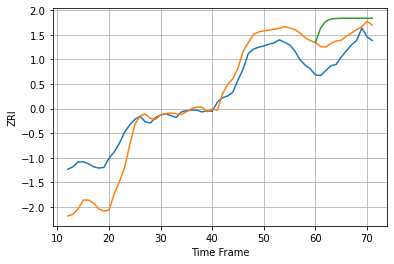

1013 38.85061422283411 32.194596339576975 56.83010966125905


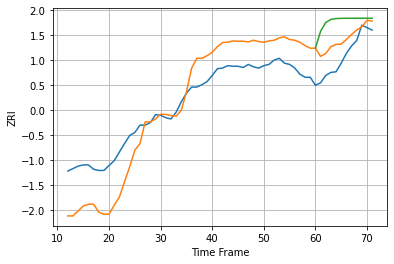

1020 46.8016368540231 32.96270711471271 61.86789752764059


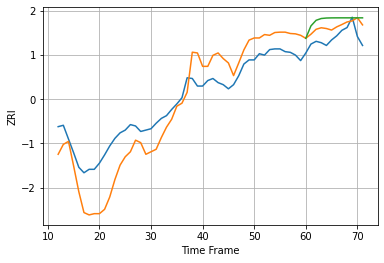

1040 37.823668580136555 18.772714330954173 28.13819673311259


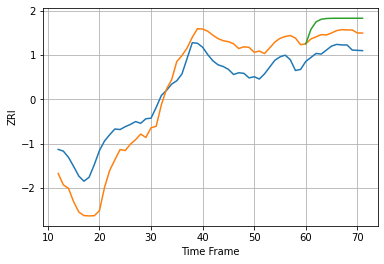

1085 47.22076062406356 29.54303709024034 51.574088674945045


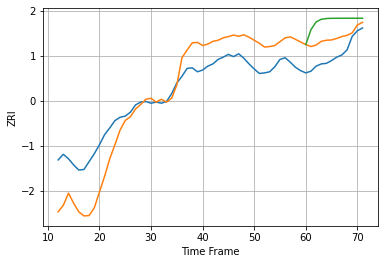

1104 49.308352616271364 33.71229292839401 62.35295910667163


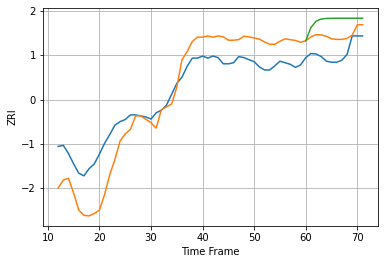

1108 51.35672480337069 35.537893505139955 64.1269638073426


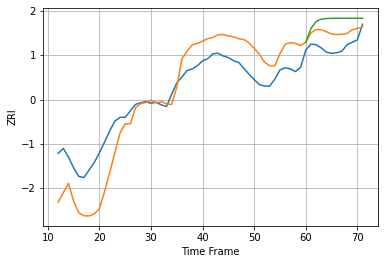

1109 50.57032298722669 27.2326710473849 48.257843890317744


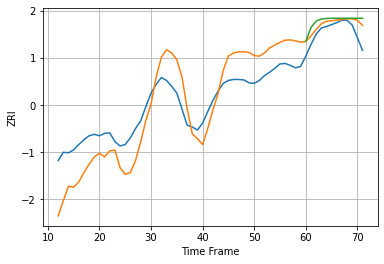

1420 54.10831824226098 21.789693441204083 28.783063485078557


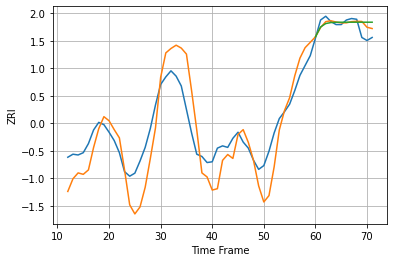

1440 33.1937706565413 9.567730825959899 11.695595951314969


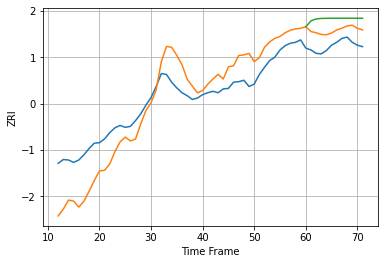

1453 53.23257662354827 34.11150074340552 56.8374146355566


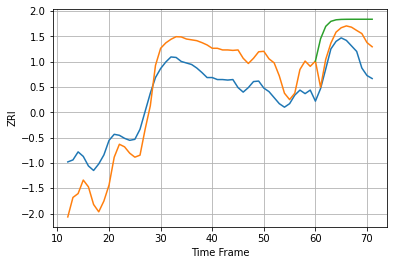

1545 56.67325088172636 45.282954453459865 78.66922201310955


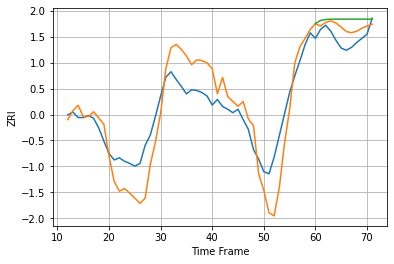

1550 37.569266263511 18.533534845524674 28.431332792989952


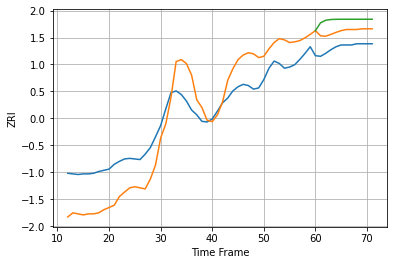

1602 48.24799902716272 27.956562896691533 45.62694658565533


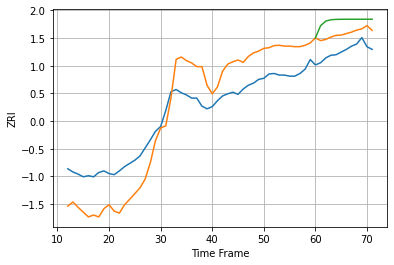

1603 56.76836750336128 34.46080128478076 57.31422848976766


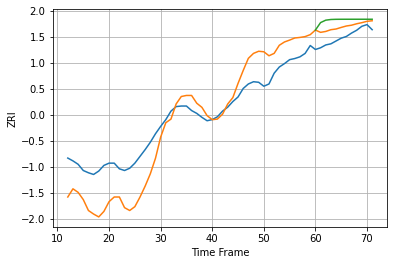

1604 46.31136435527269 20.25416265523056 31.645834447322205


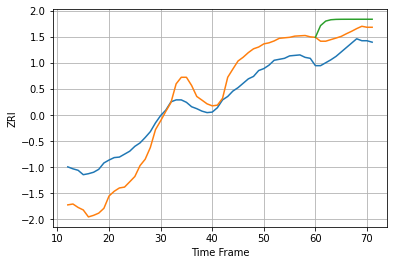

1605 52.37960267359854 36.85396957395809 63.00914169955678


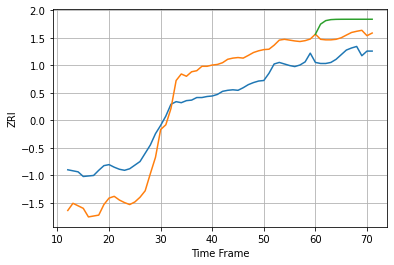

1610 57.683979944986504 39.72029673330934 67.92653535388487


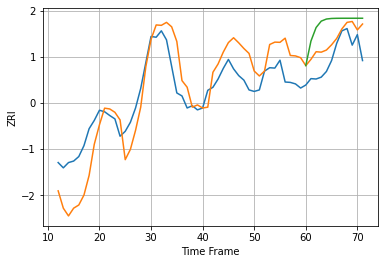

1702 72.31963568108141 53.16482475262751 96.29903826787148


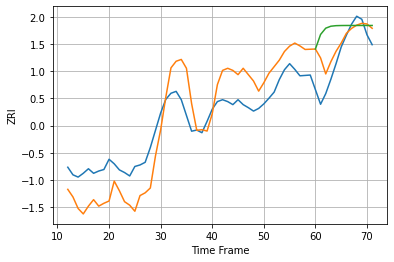

1752 74.49315804998616 54.691362185880045 96.84127362389428


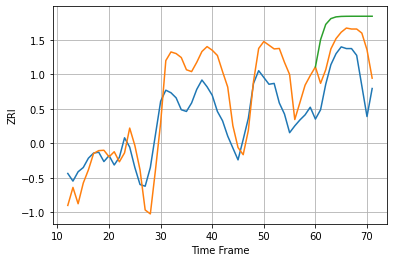

1757 37.370129107907964 39.003566032147646 67.42781171354207


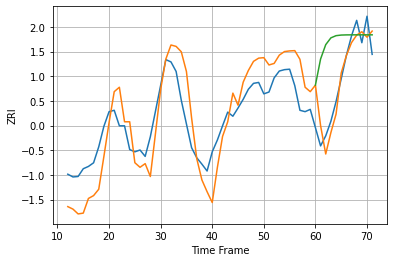

1760 60.66909836873376 41.13978037051526 113.6428468650736


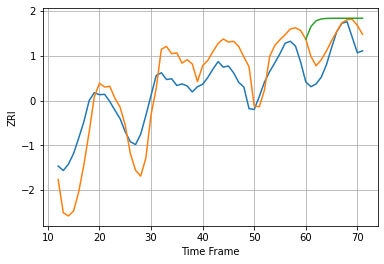

1801 67.39001947538603 50.99645109845195 98.8884554853564


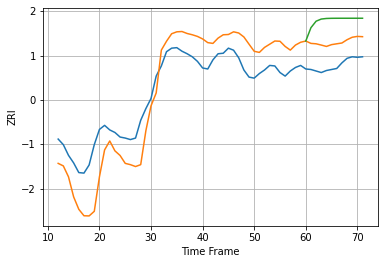

1830 53.852472506152324 46.634745352881616 87.73726795553337


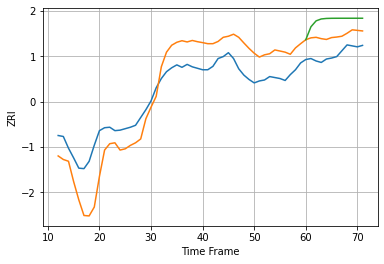

1832 54.28371936720344 38.479342981929435 69.33152929360666


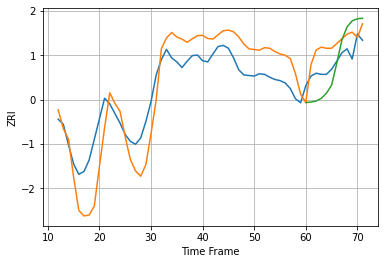

1841 48.272622903482336 34.25178452729023 38.54909443253028


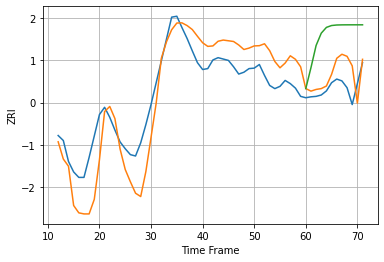

1843 60.29644492498557 41.660113459826185 120.17415601538293


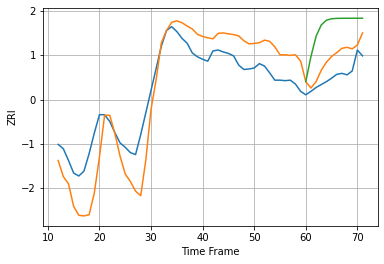

1844 58.72396714276609 38.29842550249608 101.82437775825203


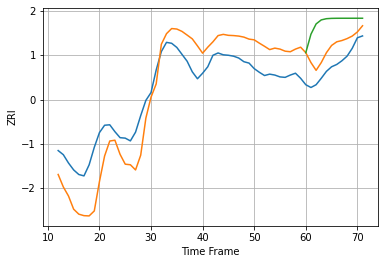

1845 61.46013670638212 41.71052716853691 95.23946992051663


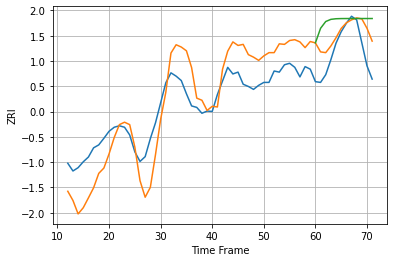

1850 75.3608574297294 63.77647211046546 99.89440466437716


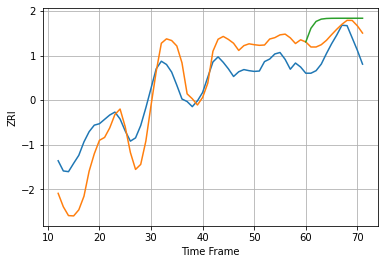

1851 74.86486563727043 55.037293719596846 91.46380348495921


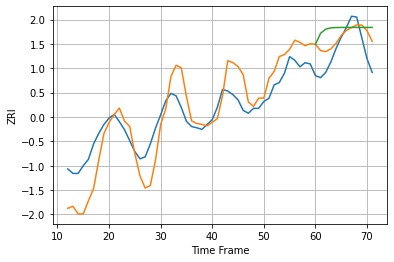

1852 59.09916327678409 47.68462273438506 70.93890097346825


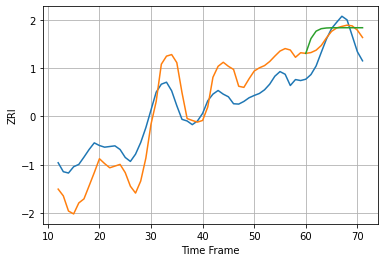

1854 79.44056051461955 45.486625414642425 66.45877194697349


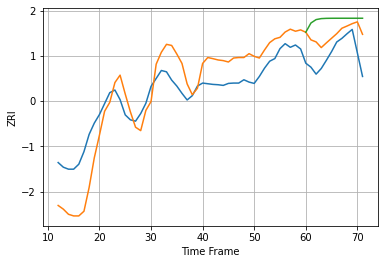

1876 80.80889443249056 71.18452687338448 114.20206865850855


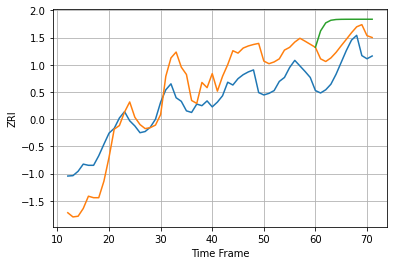

1880 68.51768904929796 62.319247979254904 114.90617464579194


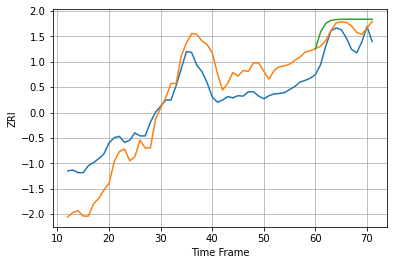

1902 63.14103318042504 34.920392001561254 51.10384798559766


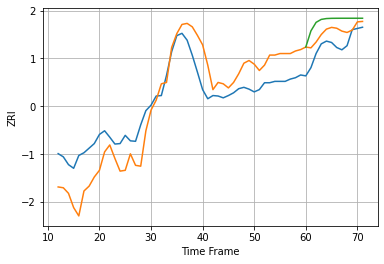

1905 57.77681432433776 33.30468666156891 55.605433926761094


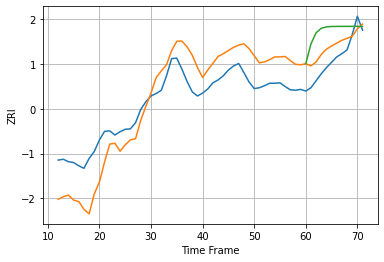

1915 65.63104925535835 40.09987153807676 78.21478827694534


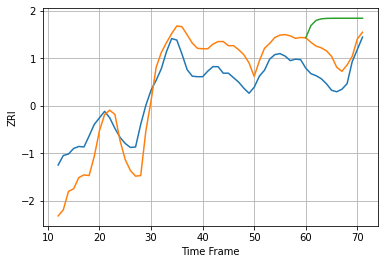

1930 53.79234082195644 49.50491725566937 111.05371580686074


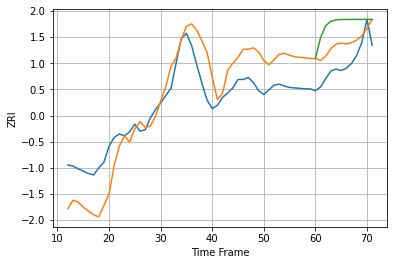

1960 60.60208808548756 48.1656177607172 88.04018178436806


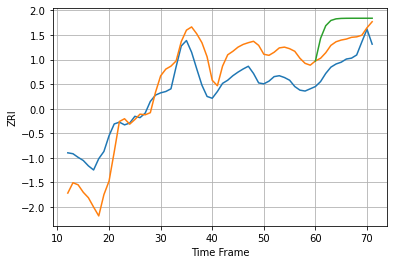

1970 60.7837465178512 44.34953198070571 83.19389597058287


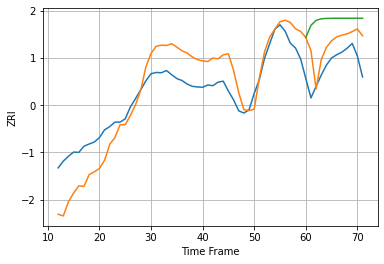

2026 80.11050100552893 80.86711718684002 147.454511122882


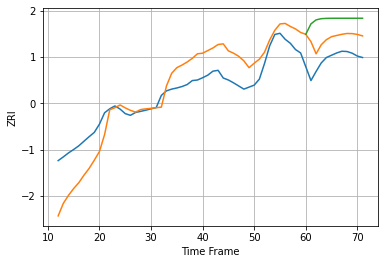

2062 83.26505024532642 79.23282688477107 141.07318879038684


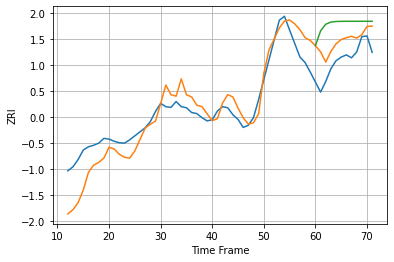

2072 50.560978500791975 61.0685578924779 106.70524393516868


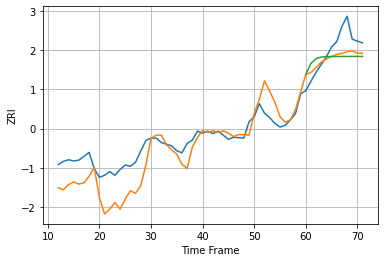

2111 47.33023196704062 38.66827847064451 46.66861200038076


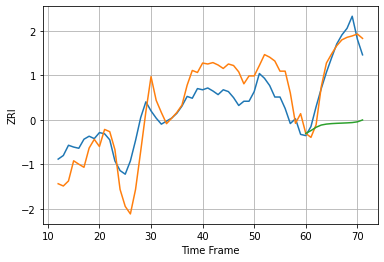

2113 40.72187864053655 17.55541939150467 111.46359673374542


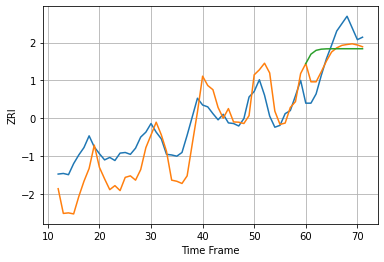

2114 39.25754893551691 30.20057385278089 45.19991287715699


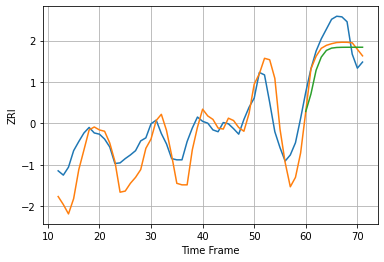

2115 37.79577719354276 28.48772156351062 37.359942836608866


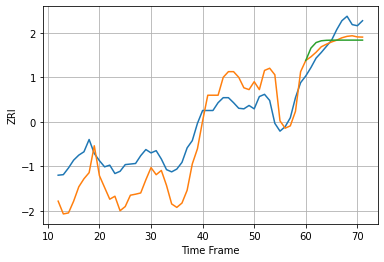

2116 49.4728379868317 21.682749707305266 27.95082091423281


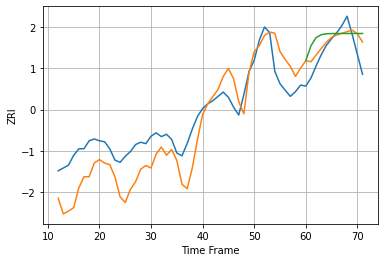

2118 57.82179822091892 32.974632175002434 45.750638929961255


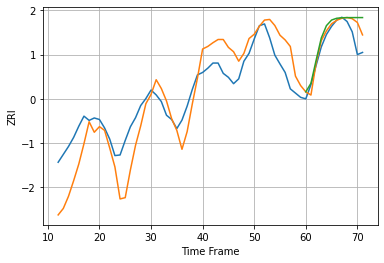

2119 88.15904996920496 39.803730426610564 52.786875907728096


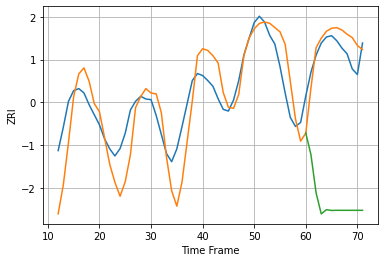

2120 85.08967103251632 58.018878728674125 441.6741665272575


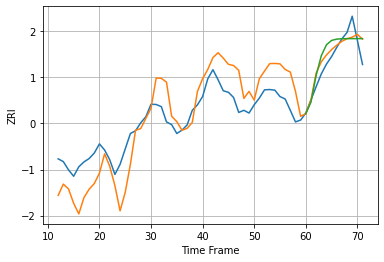

2121 83.27382189705288 38.20600743274378 46.05539226781182


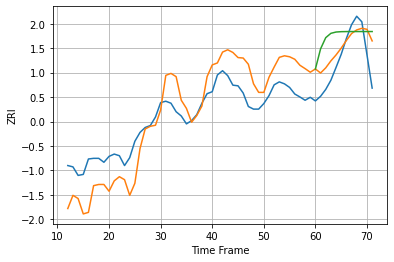

2122 80.94496702477053 66.96981352602523 104.41602472821745


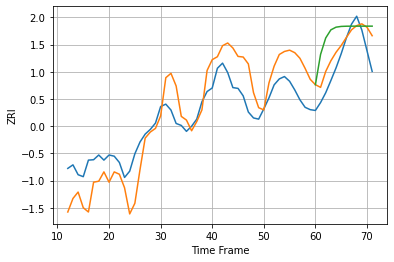

2124 69.99750008375129 46.530543835629324 86.21852774164138


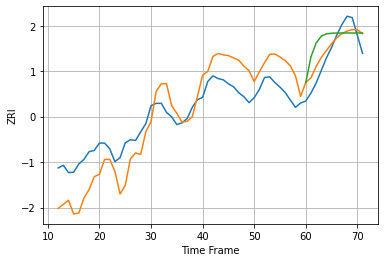

2125 78.49005965808323 38.609229119292586 68.81420213500039


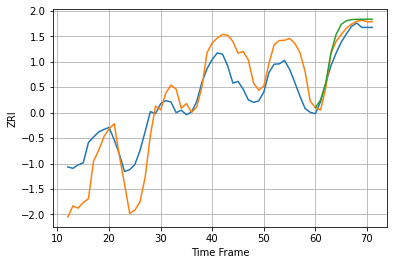

2126 81.69495321686536 21.18614751074025 30.243582060115987


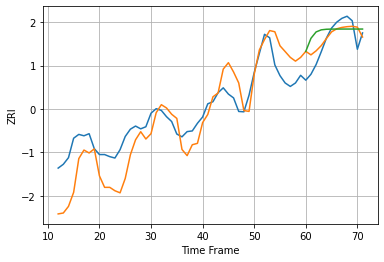

2127 71.0234419963277 39.12714754522139 56.117108295907734


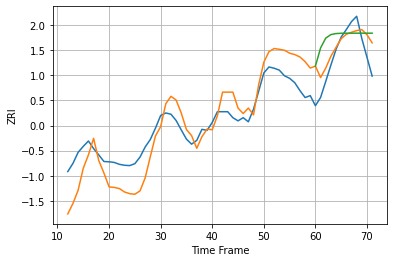

2128 68.5136782399395 59.880791806135214 91.56891935093621


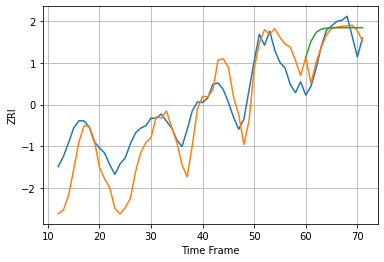

2129 68.98720357852659 35.891130113530494 56.98477503157157


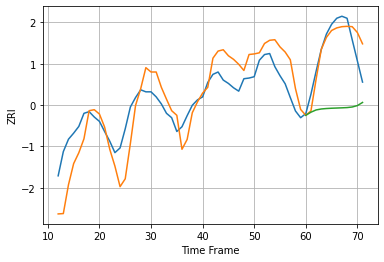

2130 73.06896194356646 47.869517739034464 190.79340133419075


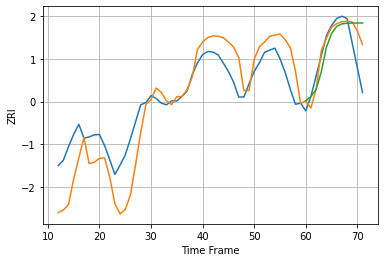

2131 99.85428532933317 70.71693599836223 93.85213420907945


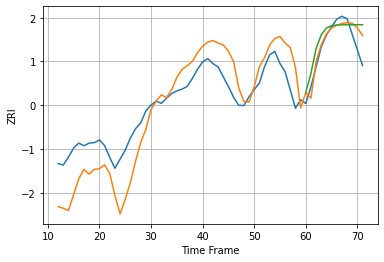

2132 113.0299989318842 51.55149359689223 68.66330716489882


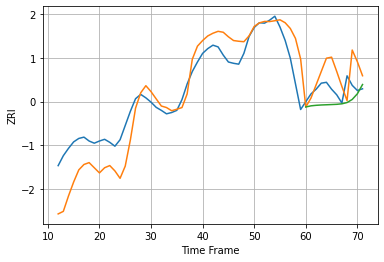

2134 56.954652131873246 49.495899369798124 34.58419033064303


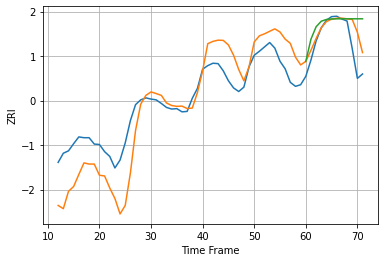

2135 69.26763714169482 44.53567807469325 66.41624853629781


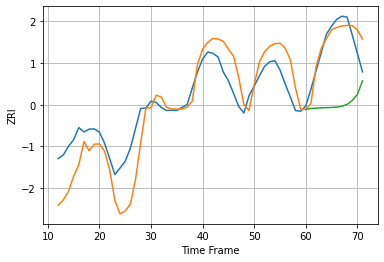

2136 103.55901732590732 54.01370549639943 246.72326095875133


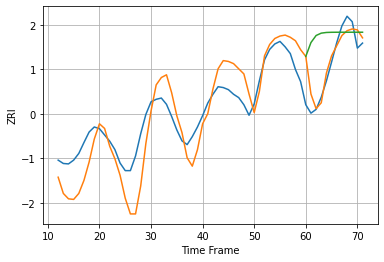

2138 59.25373234437929 41.03127905733375 99.70007650377167


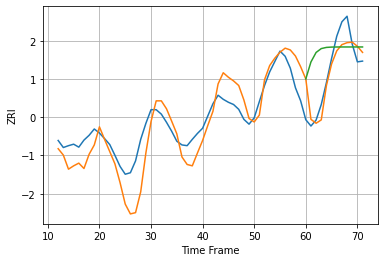

2139 55.85926181522951 47.66061390173275 101.3787239540033


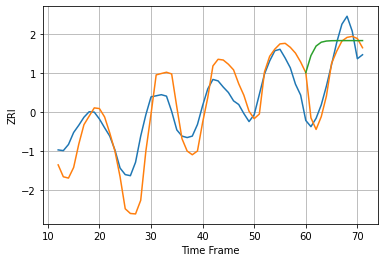

2140 65.51153897759035 50.40568662175879 113.96370395379434


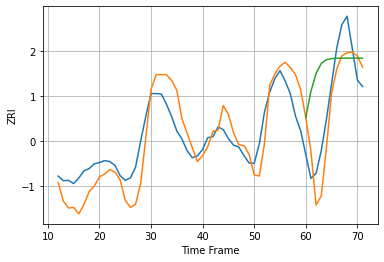

2141 48.11010959880859 60.914836292517116 115.43263614013722


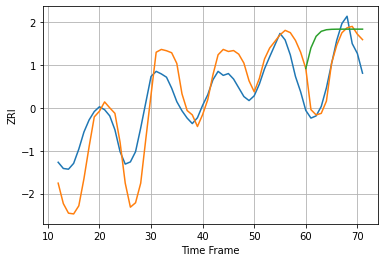

2143 75.14138920332124 50.59270194230303 128.1926879007179


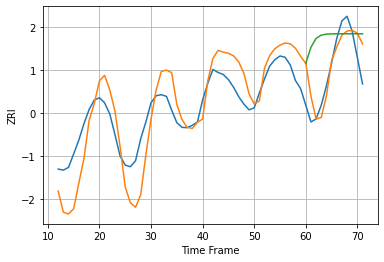

2144 78.13894384758517 62.81014873755897 137.84948308321282


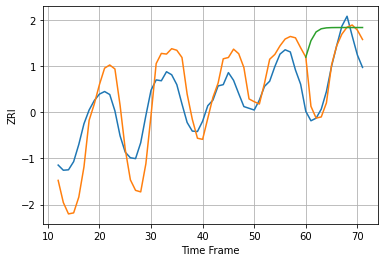

2145 64.63317844475856 47.64821412484922 119.41806903284137


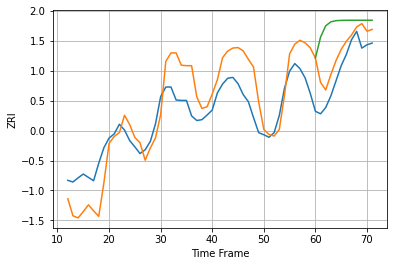

2148 67.01543892865286 55.3583939087936 119.71832645948234


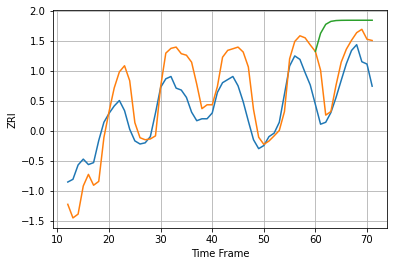

2149 73.27154946376716 76.15590942453424 166.1715778150103


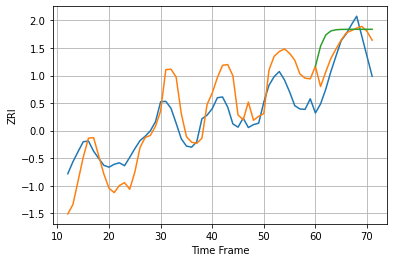

2150 68.10723531654425 57.18539410329562 94.27292244870513


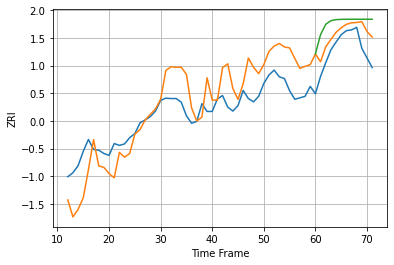

2151 71.4422514677385 54.00942568716488 83.5176374562281


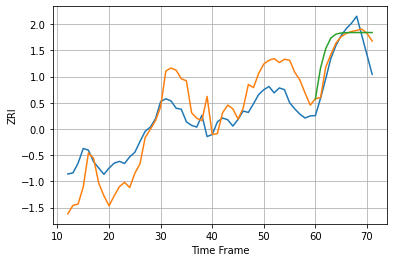

2152 72.71330344838736 39.97315957742305 59.956030715824845


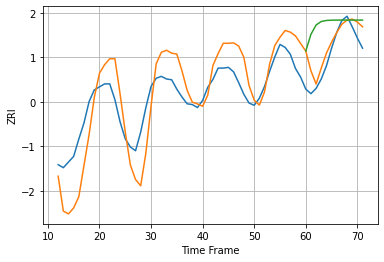

2155 74.00006928626472 42.839982187649845 98.59594229272139


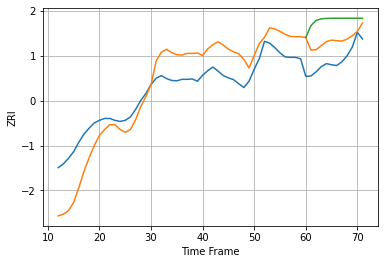

2169 69.0238326133598 59.595171356970475 110.08838379688217


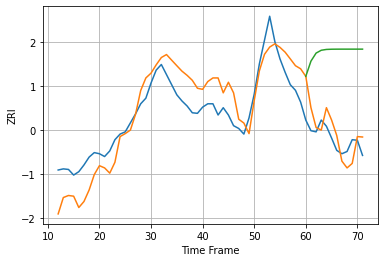

2170 40.96602208043309 35.23684360438337 155.23732716806308


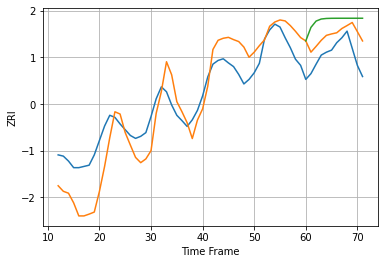

2171 64.78336266839432 55.5691398041777 90.14237820107135


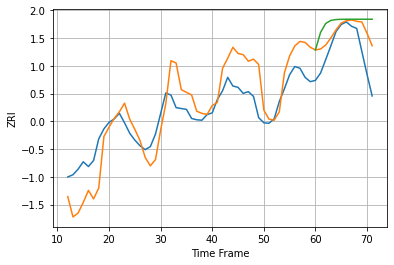

2176 59.27857753103742 55.5979766299236 81.05880976917602


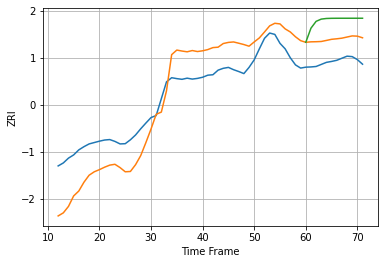

2184 119.51401642026119 99.7676791177192 178.6427196998801


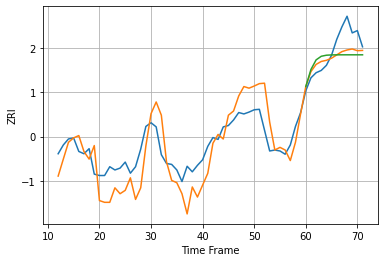

2210 48.02349749459863 33.61974583807621 40.36561375071616


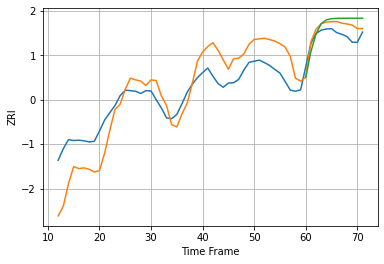

2215 87.36079252746586 34.9737249620731 51.4665189949458


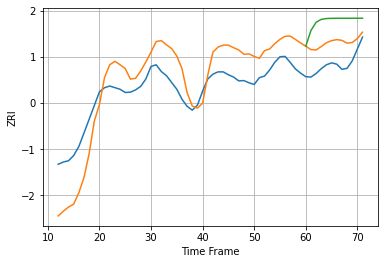

2301 85.79050222049344 70.93241711747606 134.84973010475744


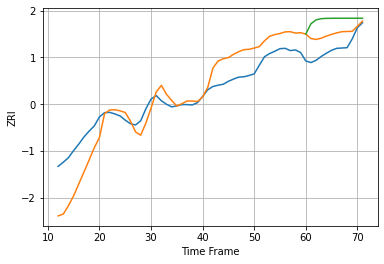

2302 68.15357307501837 52.36115837230956 92.42137900496057


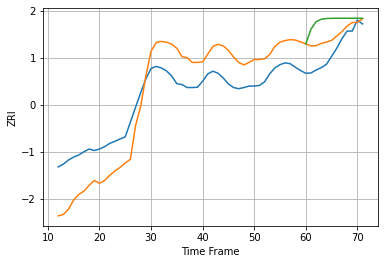

2360 100.3992134076076 60.378383520105835 109.50033372709176


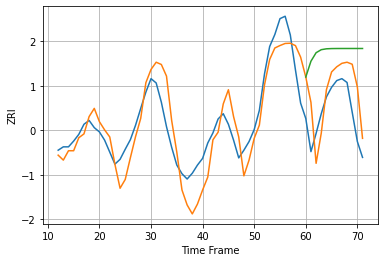

2445 46.368875753113684 66.36612511437534 137.1133079876734


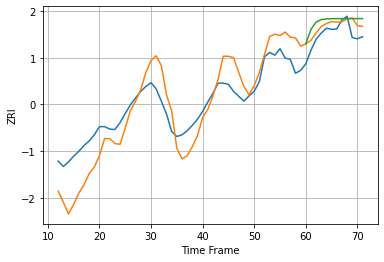

2446 58.938605187703715 26.173786724582897 36.70269633413201


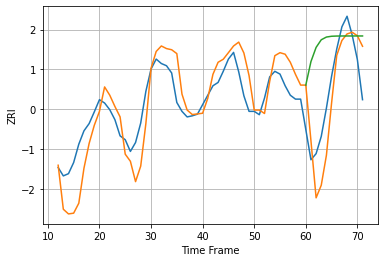

2451 44.408899430288635 60.465114832774184 109.01799898050116


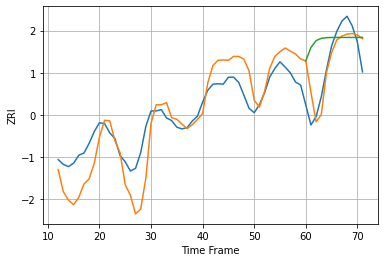

2453 54.369277060725096 47.59292266424896 94.00074186580896


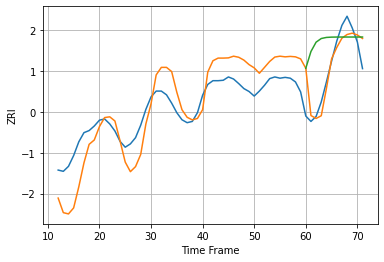

2458 57.27792083256681 44.358888295592976 100.50698153369919


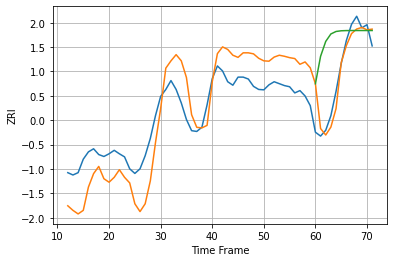

2460 75.81284439290033 43.91991880374265 126.62404512484433


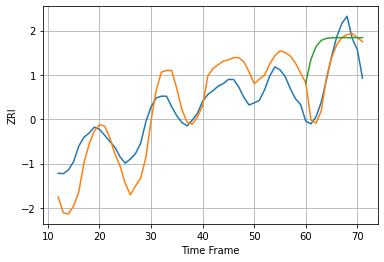

2472 59.31935230988517 42.12237725218568 94.81998538538984


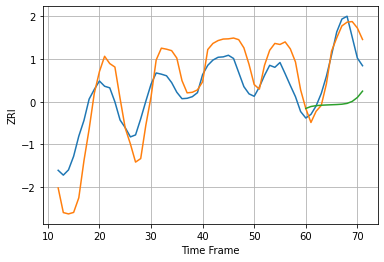

2474 66.50625013797338 34.80806574448446 124.42182933568239


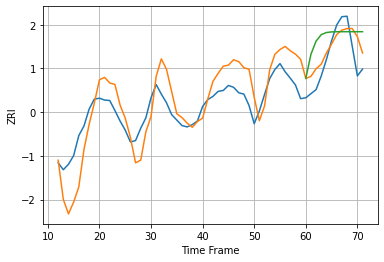

2476 52.18401673131813 39.23374571286452 66.05740019167528


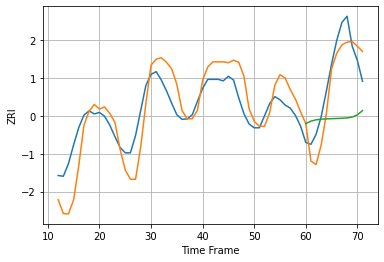

2478 59.61528699629164 54.811008629730225 148.8463534316624


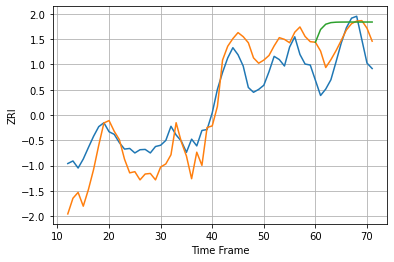

2494 77.08386144215486 74.24347632690301 125.75210100312023


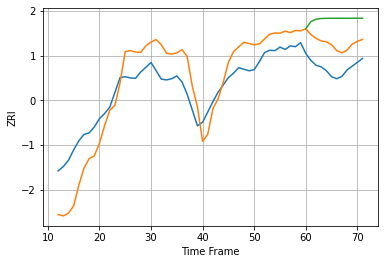

2703 66.21295007898628 63.46660845323908 122.86446084480609


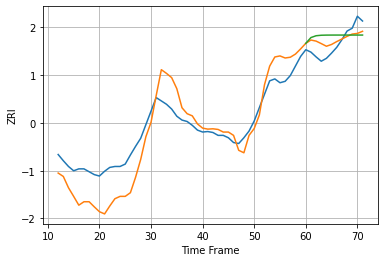

2721 46.60852974752294 23.096235904248918 33.19385190707036


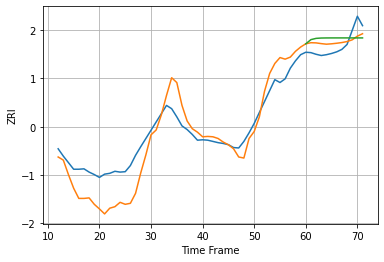

2723 50.04260235108565 25.679385874650386 34.336548113809464


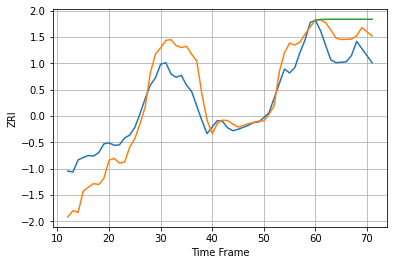

2740 47.62404814201345 42.78858162905147 70.03115041062634


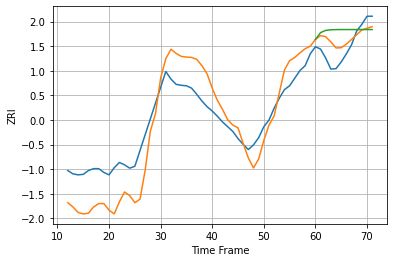

2746 56.76867132173197 30.20472678096247 48.58535228674296


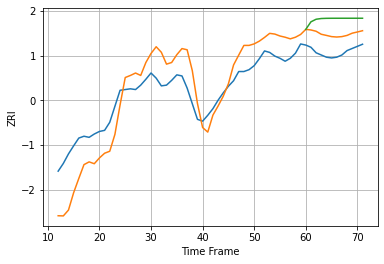

2780 69.23411333725265 49.45557920709938 88.58996103746692


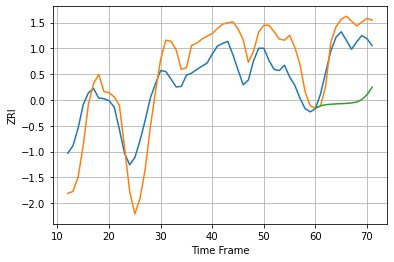

2840 56.72130477550763 32.39911537966129 99.1192924286718


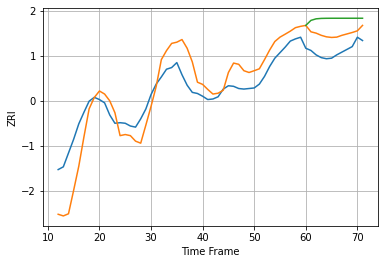

2860 41.21035957324977 33.32888803784506 58.7929017123786


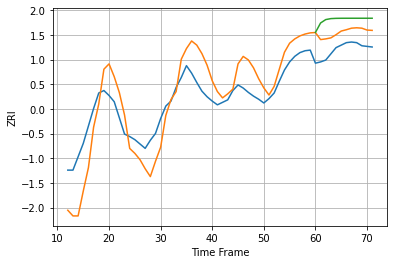

2861 40.773840977885314 29.138588742708794 48.79606412106273


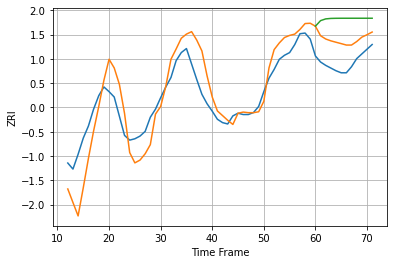

2863 33.43523390037625 35.49640967673066 64.78941863544019


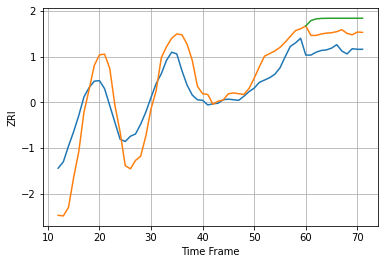

2864 42.50774344671913 32.010223524555244 54.47000354439836


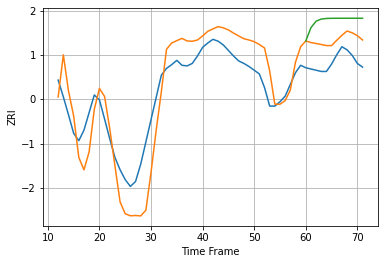

2891 43.71964760709142 37.87851403052392 68.36723584537064


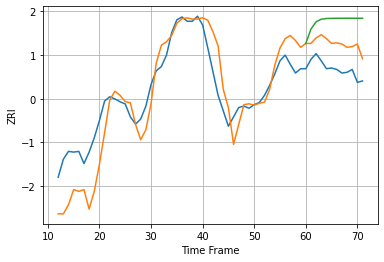

2893 35.88407087619016 35.89920287884017 67.79277931743167


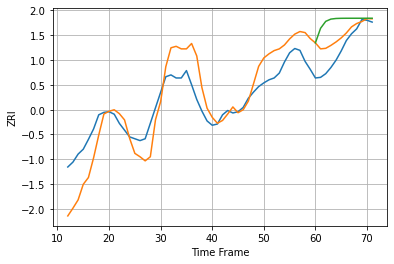

2895 38.37021574367891 29.092359301573982 52.35491821931044


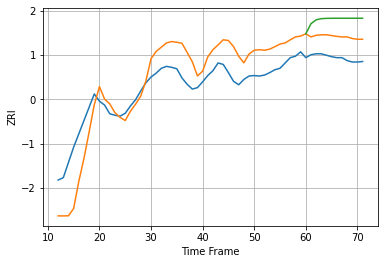

2904 52.648312547976396 44.08845257797157 78.59377972831396


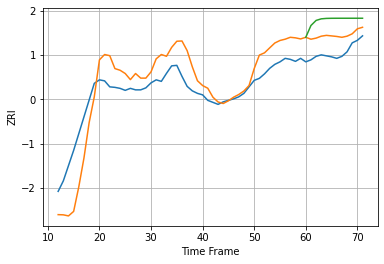

2905 47.47445709298033 36.260003592752916 65.4455170801432


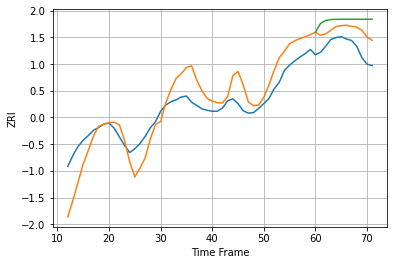

2906 42.244796305851125 39.13584250075561 61.43897736327078


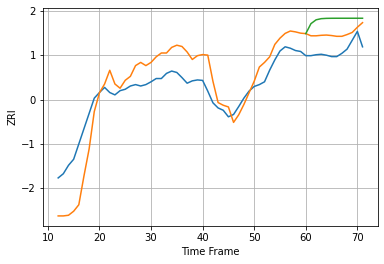

2907 52.93203652193778 39.23449413863855 67.6383163887405


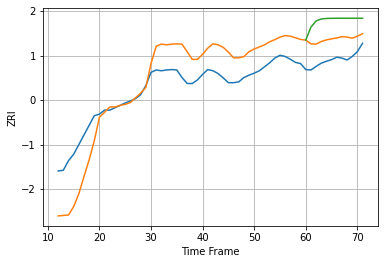

2908 66.49283334521887 53.45683943239849 98.22523881804221


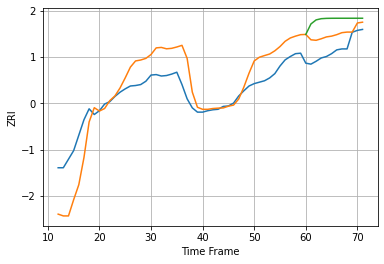

2909 51.39998655054806 37.457721127244696 65.84640216808226


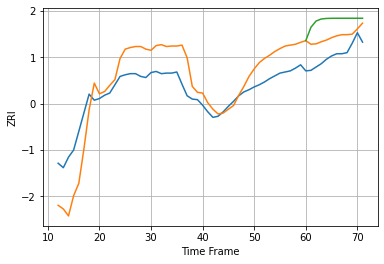

2910 46.032092265488004 36.07886682191482 64.07372956745732


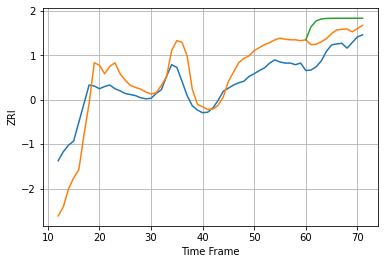

2914 44.5950336726715 33.26799160432156 58.902046431808685


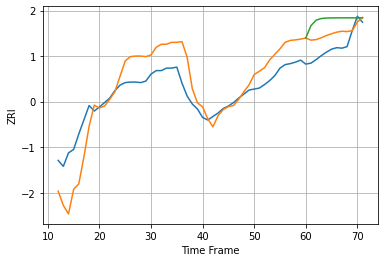

2920 47.12594738015583 33.04272760533508 57.850232704649834


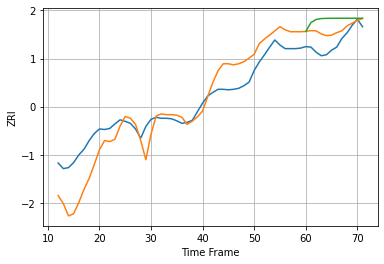

3038 42.9304312584283 27.89901837580902 48.184348674956055


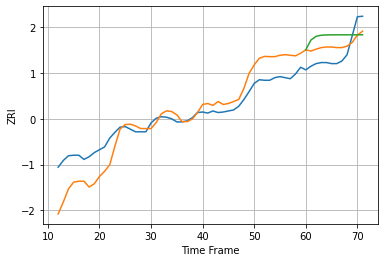

3060 35.837174804946436 28.81286946390496 45.599796146916546


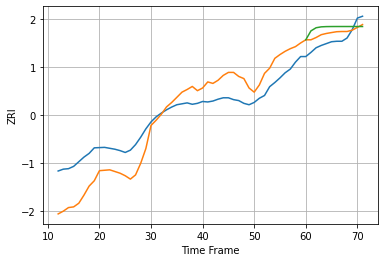

3102 51.22673749643275 21.863489949419513 32.73820827526196


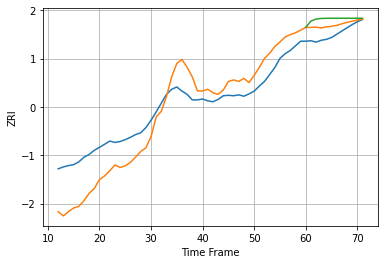

3103 53.809754155568484 21.646388000749436 34.01019351989798


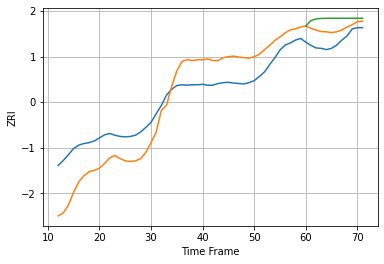

3104 63.56772388423872 32.570481821373505 55.44262484555261


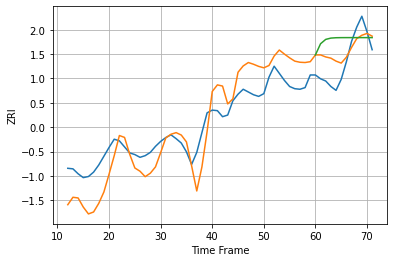

3301 42.8057150585044 34.13109067005916 56.5601152091114


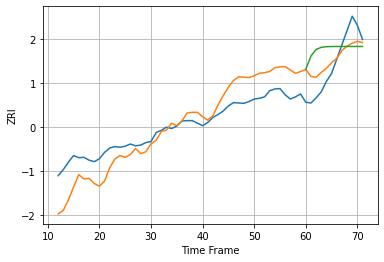

3820 55.2222561685085 51.691886339213035 85.53307586032768


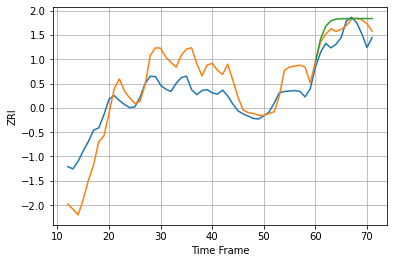

4101 54.64652237155498 26.161007669601524 38.829897018892105


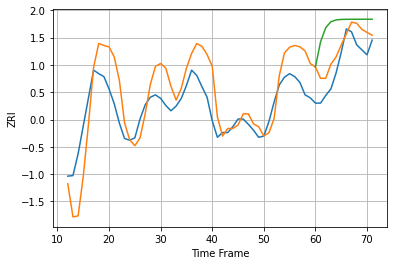

4102 47.47225398571844 33.49729169083716 72.08828285927073


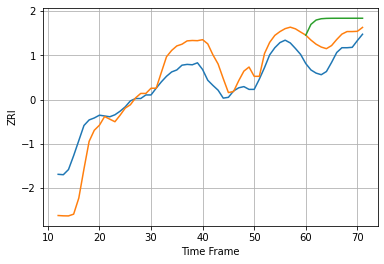

4103 58.324188915335924 51.966582845097214 97.91432037731826


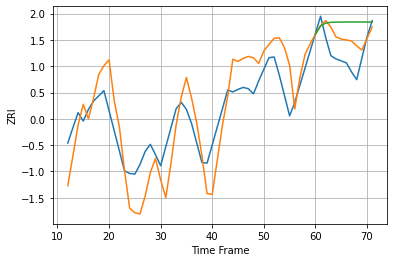

4210 44.74260426677174 31.150612977952523 51.450395151693826


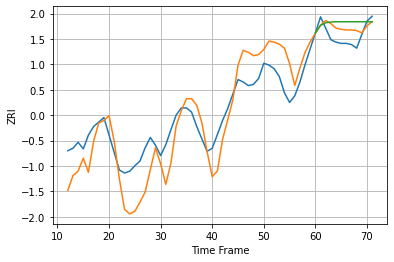

4240 42.86893567818662 18.801783347291536 26.98671916458191


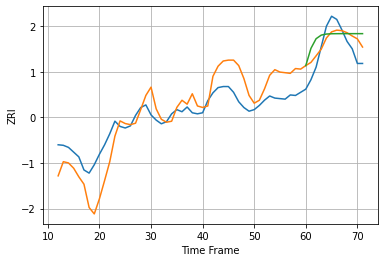

4401 40.888101983811595 28.07047235142308 39.42836744708344


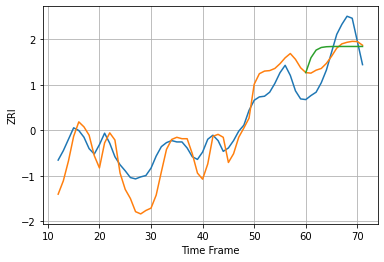

4901 29.91749494632164 27.631960514909327 39.48499496417255


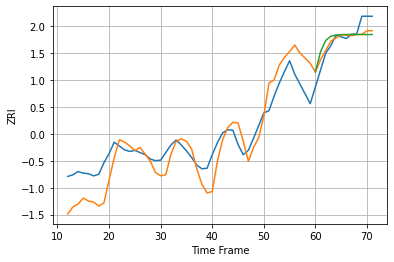

4937 38.050097549345665 17.880984553337747 22.72865861697288


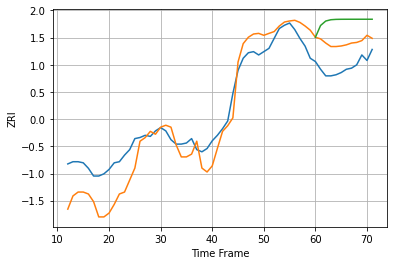

6010 20.404164488728107 22.928562242248113 41.82033818997095


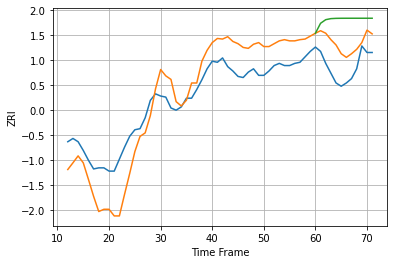

6040 24.199884392367323 23.224826858309864 44.51565801675035


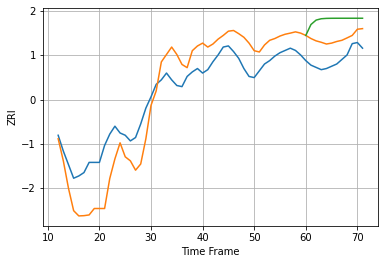

6051 24.658878309084542 19.31581040221746 35.380580558297694


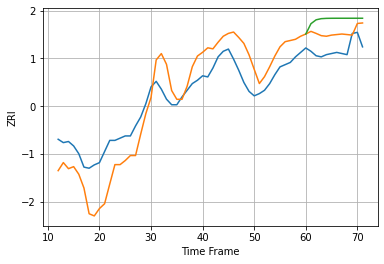

6053 23.638155743049147 16.336194351903256 27.494338833920683


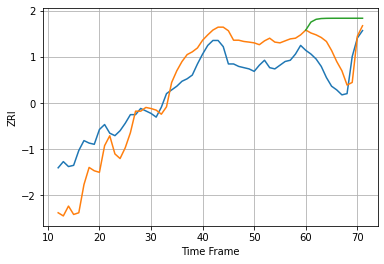

6082 21.024552113228243 19.5511339416716 41.85064357033767


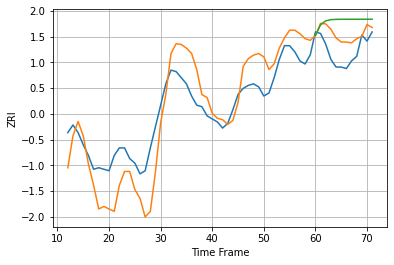

6106 18.14046541785282 12.763867584394585 21.744670319839006


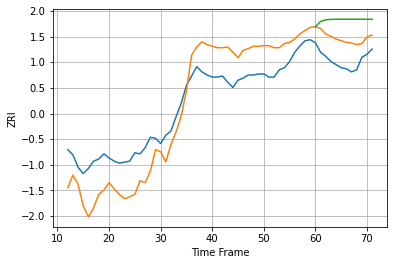

6108 26.97449758427797 21.87966088875376 39.38915786274108


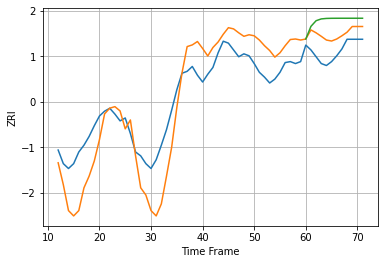

6112 30.16370255871537 18.35738605621714 32.67451306683758


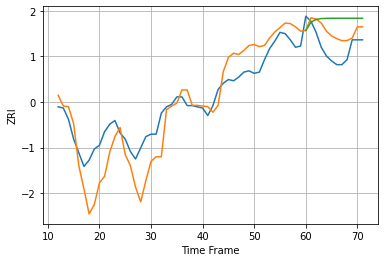

6114 19.300670151696238 15.030637086758876 25.301742643031858


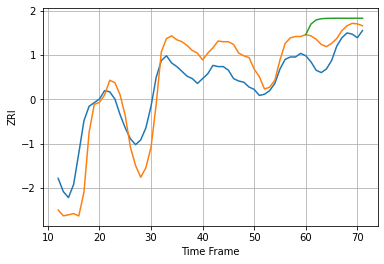

6119 22.012417963319155 15.494556682158887 28.22968796323523


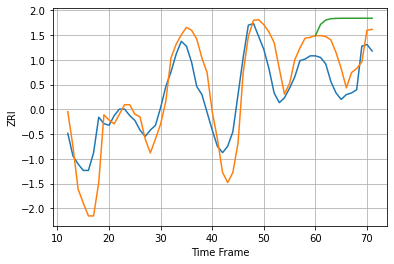

6320 16.706347121598963 15.776469980372847 35.137837553278366


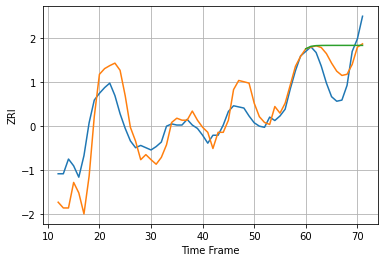

6360 19.021358221580478 18.063392849808697 29.238379527835903


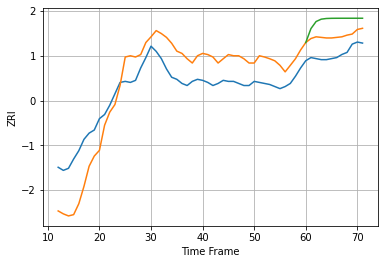

6401 26.99426656842547 17.76885347726334 32.27269498487713


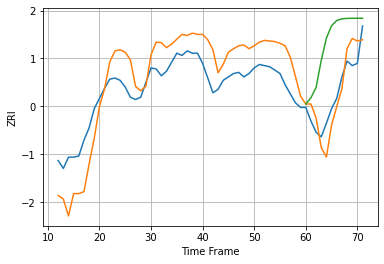

6405 25.055984653931446 15.759482407302587 49.877851351756846


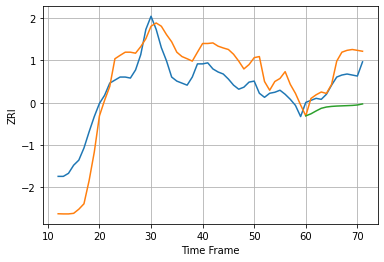

6418 26.03992517003451 15.633118739129406 24.735826976521096


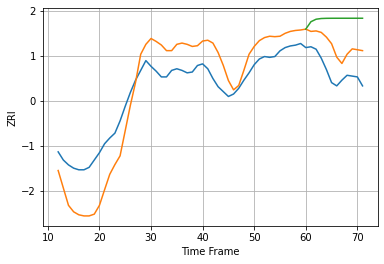

6450 34.91573860197026 32.49807003002161 64.59605257995227


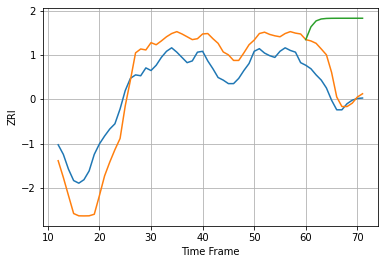

6451 30.151908576069907 24.479928930061675 83.75379404105458


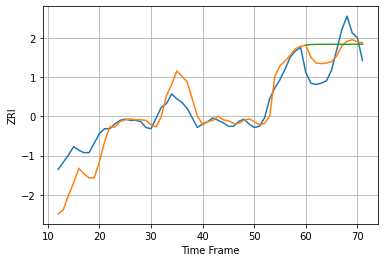

6457 14.61537051553967 15.189949032254365 22.686736130287844


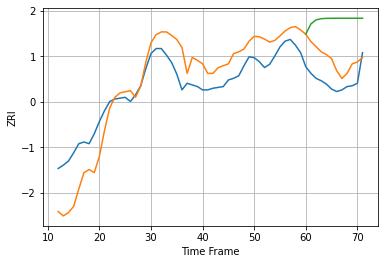

6460 30.81565189928618 29.99439909081669 74.24886766345679


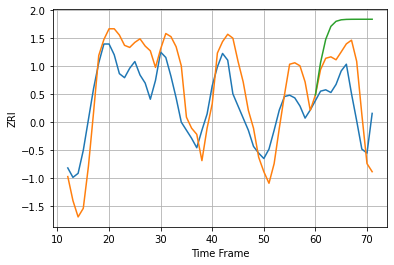

6484 22.481752921849647 26.484189505307402 59.031498105097924


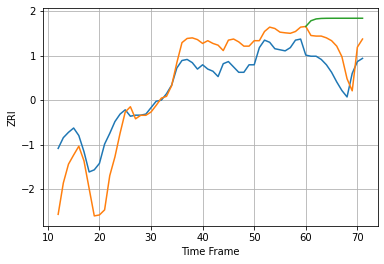

6489 24.221085027143555 23.435729668554742 48.35742968097168


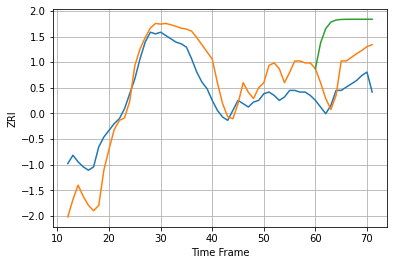

6492 15.409205890881905 15.868069608825264 39.97725397308185


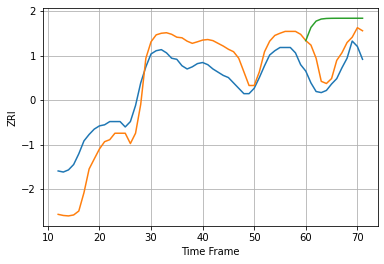

6511 24.80886555986465 20.225585182989164 50.004436348912215


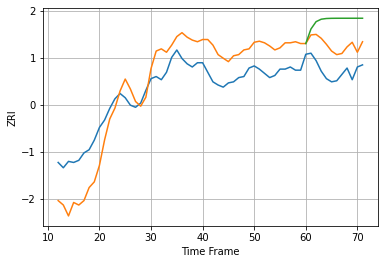

6512 26.242727879888246 24.44406180198598 47.487340889738434


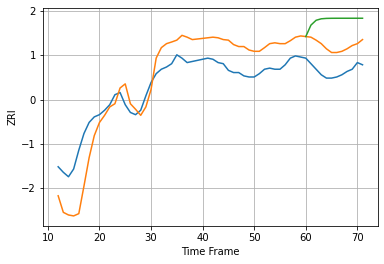

6513 22.95960445183777 22.875870041951526 45.73260213433752


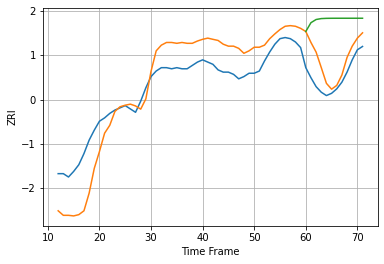

6515 23.41850756395567 18.850254431766952 52.61944785891792


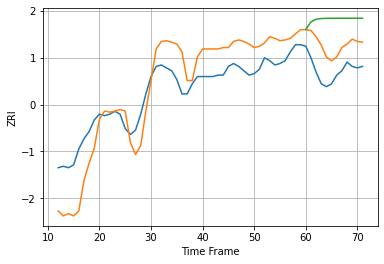

6516 18.936048240595277 18.29331859327434 36.02447467682922


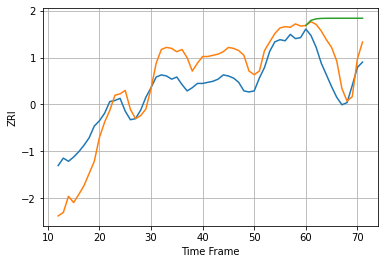

6519 23.954930973359474 22.184495273204952 54.5718261006807


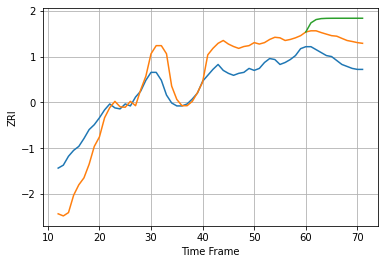

6604 25.26344197773633 23.003488872607516 41.03490851194533


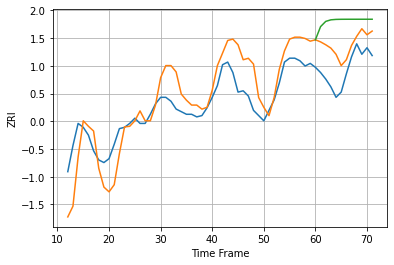

6605 18.789112332288695 20.676880021437217 38.588796690336586


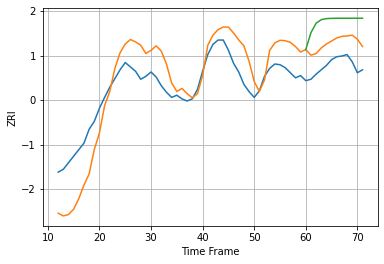

6606 37.19918550967882 32.59444982620196 61.476849977618805


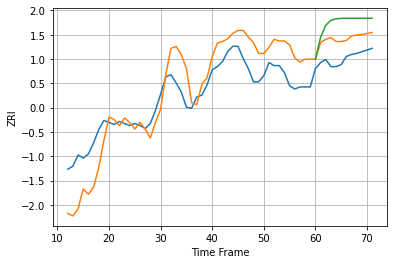

6607 25.92117266791417 19.394170246341407 35.36568723244337


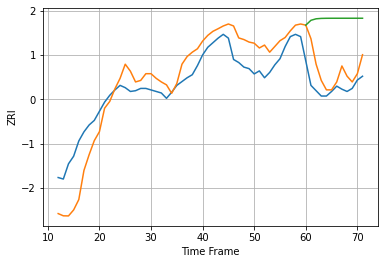

6608 30.905611578340594 28.824906682133125 89.07520749022989


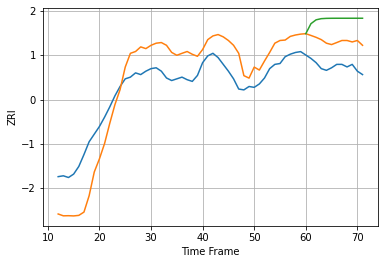

6610 32.474980594746 29.957685255545766 54.59882470220628


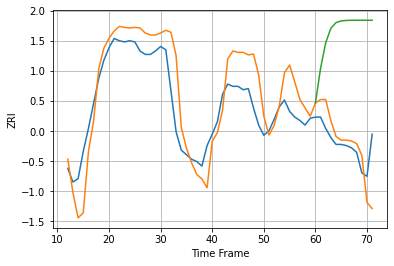

6614 24.792606674165302 23.197111272411746 102.00504169052472


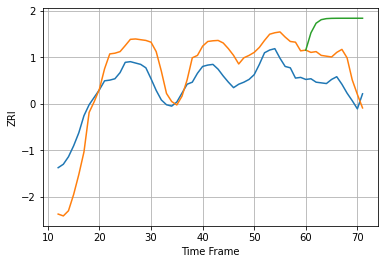

6615 39.7779424447033 38.669914456453355 96.68132498322365


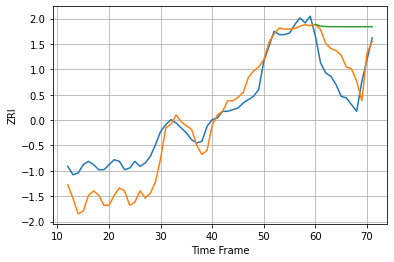

6704 13.501287010741638 16.686008324405105 33.201558408697586


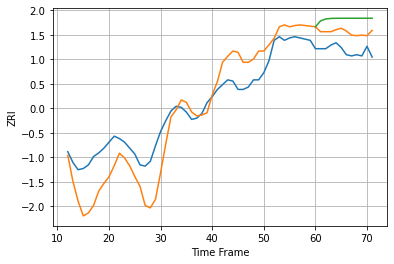

6705 21.504448612755763 15.969875138274624 26.506556937077093


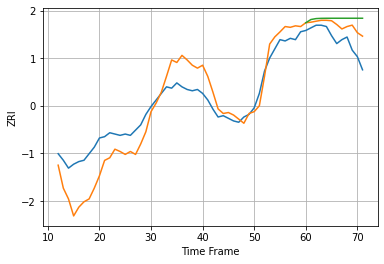

6708 17.1963398465297 12.678256478415719 18.682110782272076


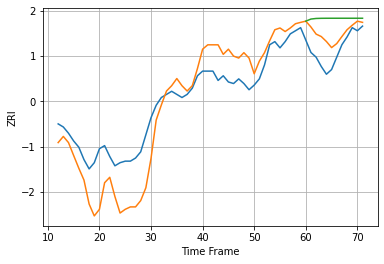

6710 18.17795405501405 12.337450504146991 21.950793447757295


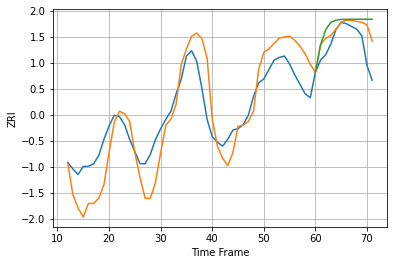

6770 20.41631320559795 13.648345887034347 18.849208518766016


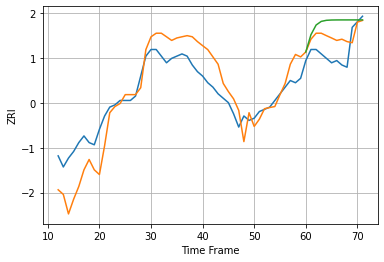

6790 10.556883488617009 8.22376681326605 13.796310984621242


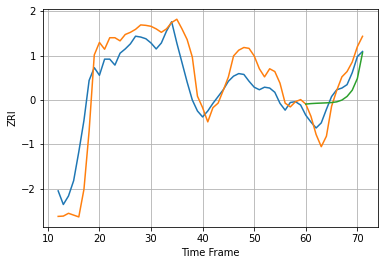

6810 29.159716993122412 16.372585099511017 17.849088195610964


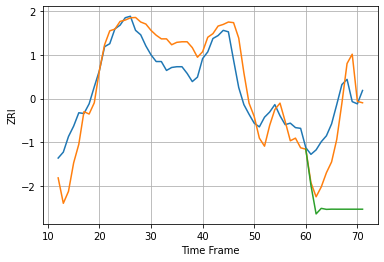

6824 30.415401254379347 42.72254576819554 124.34862937034565


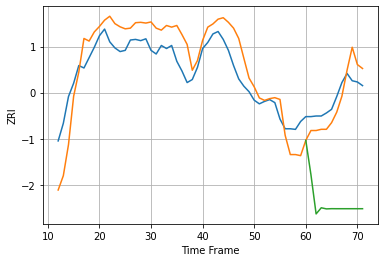

6825 39.916603719235425 29.075840253714926 174.7426758100099


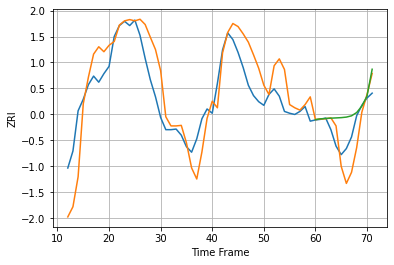

6830 44.91639856345722 32.2012384995024 31.166239957982462


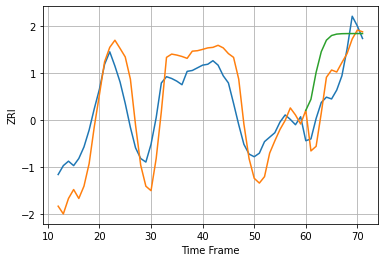

6851 30.762826171002523 21.239361534009344 45.90756635691901


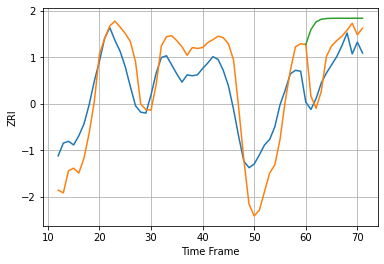

6854 32.97788244040432 25.109853568168987 55.22908841380106


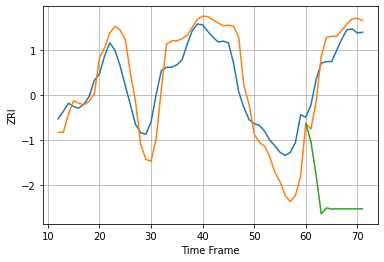

6855 32.35297025986893 19.81746976935733 179.1936278452906


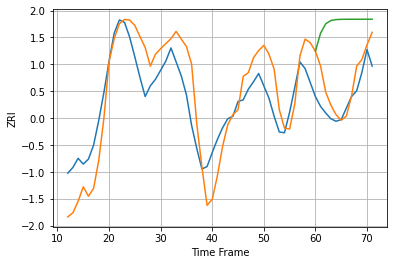

6902 37.126283656361856 27.936983817817467 92.98572463097048


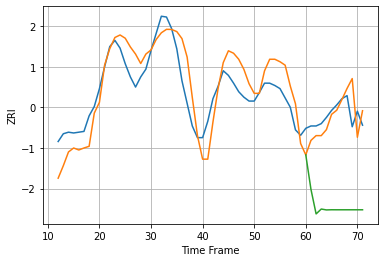

6906 28.776992917366353 25.185567740581504 116.30546475105892


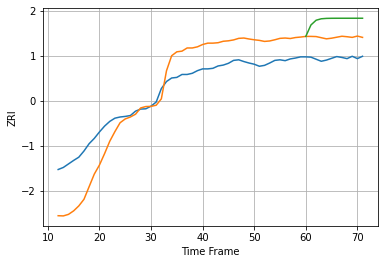

7002 90.97566477964347 71.6504394425693 129.366821449488


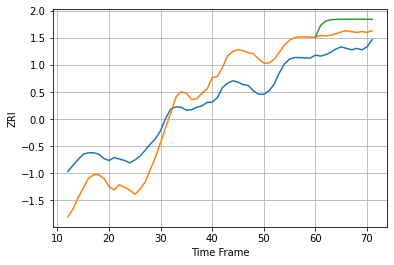

7003 53.640476967766936 34.67465477429956 59.27384493370022


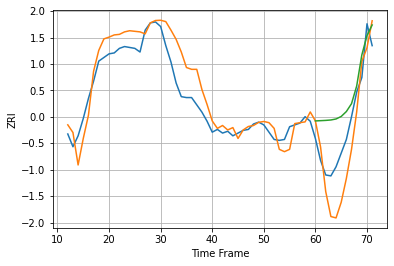

7030 19.4351498128813 34.534612683633945 37.082251570456584


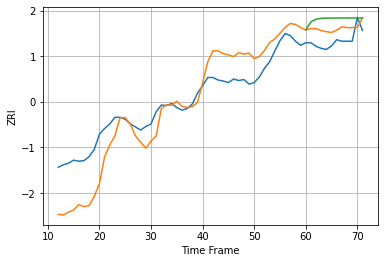

7055 51.29684125611306 27.90971466752817 44.682931364373175


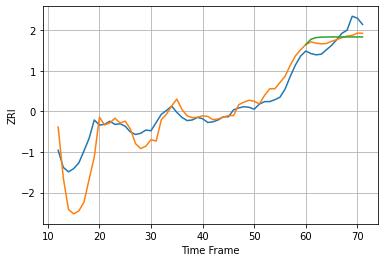

7093 27.695317845201377 15.811734608213623 20.779262997893667


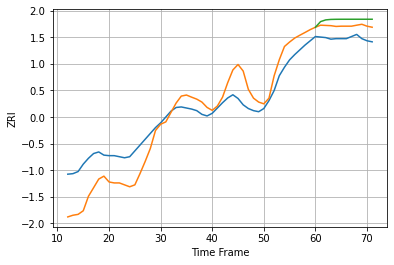

7109 42.63695584548458 23.410004389116917 34.64026641426549


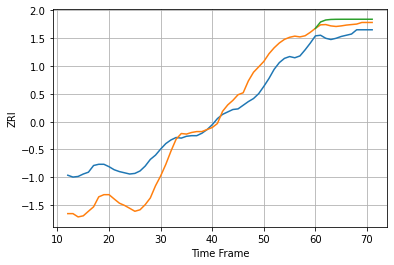

7111 41.620123256258154 16.259980366243187 23.928268823963293


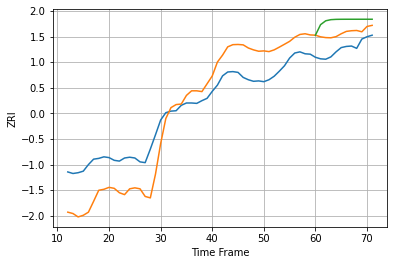

7201 73.18915404703496 42.56393290386744 73.14504608402002


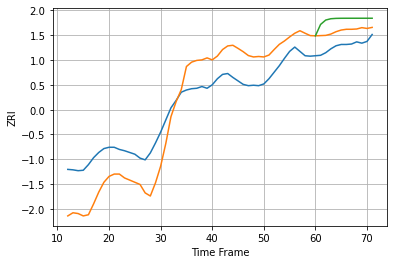

7202 69.001558769009 35.09807826159002 59.85371326522081


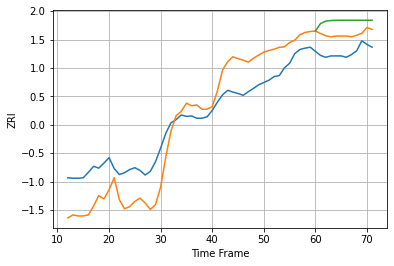

7206 60.99728692190524 40.73387482075665 68.33218466049617


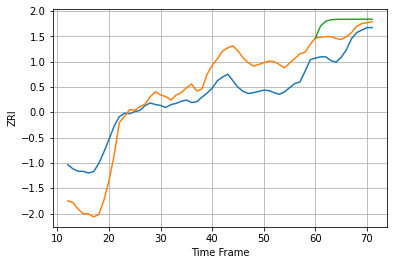

7302 64.28396658285779 38.34031598310268 67.6311804921802


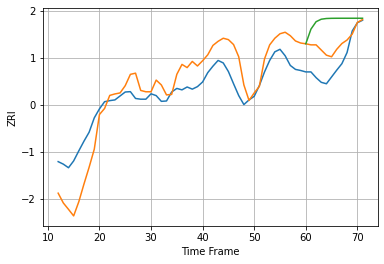

7960 68.0131952133845 61.6452460805356 123.42830787197


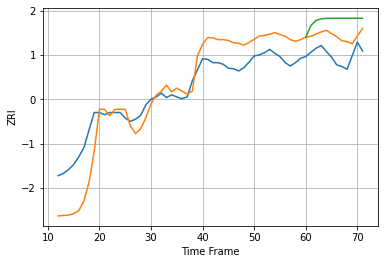

8901 44.35051737662191 36.62550151180078 64.5480167453432


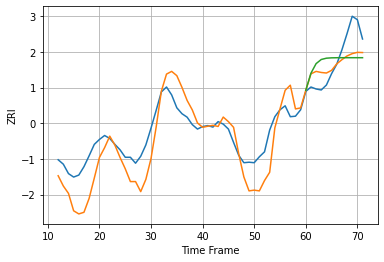

20001 45.513827138562625 37.76419290247368 48.5763914315793


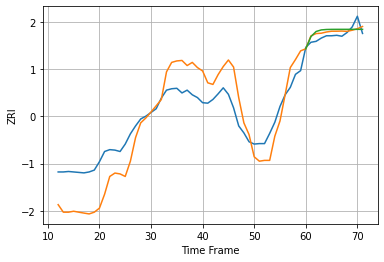

20002 57.96637710920628 12.74413946936021 14.765861203804839


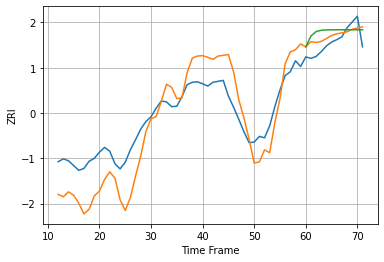

20003 56.206361090801146 22.8615470851726 31.781577291996893


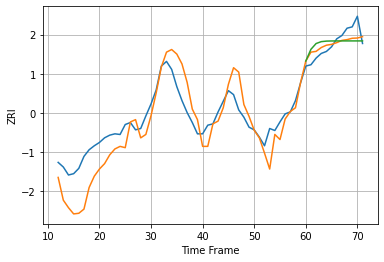

20005 33.656589783434356 14.599745893519014 18.248757565504295


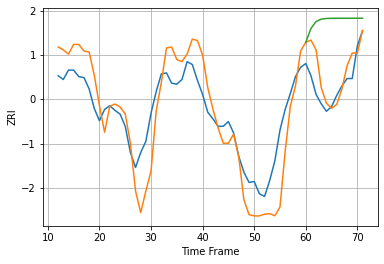

20007 31.81832353894076 21.793593154410203 69.1782699125748


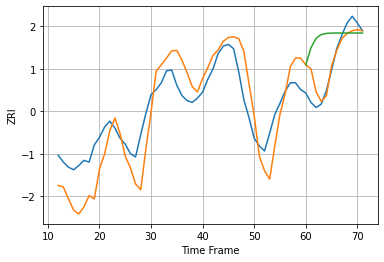

20008 32.309083758871964 17.255293603747916 46.360638523105784


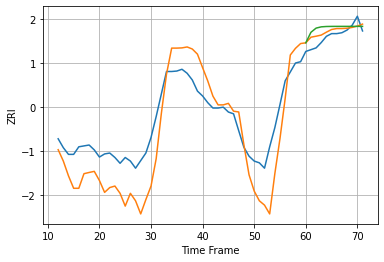

20009 67.9103561534147 16.526375741325516 24.174434674679194


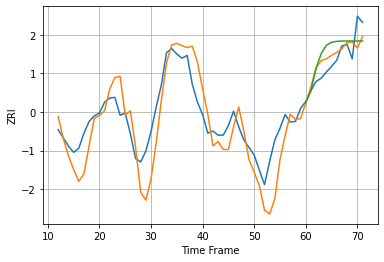

20010 35.88710547537003 20.497404179009415 25.71580644812339


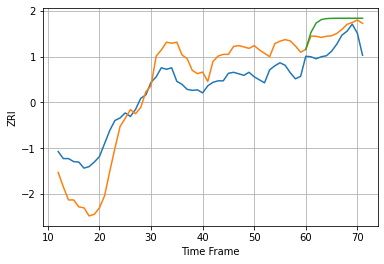

20011 57.49570083732345 33.3686027351952 53.08230530562674


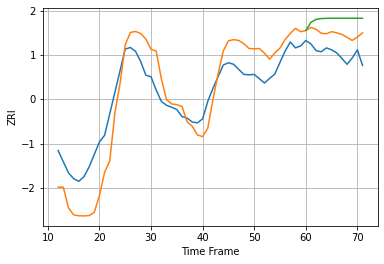

20019 69.27516571522584 51.99740454869052 88.33693914988892


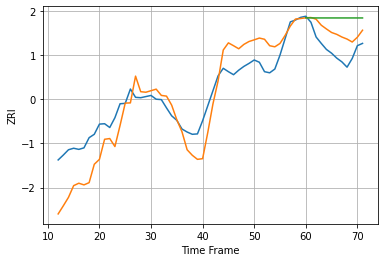

20020 65.41339532735964 48.460925962214475 84.8501498323404


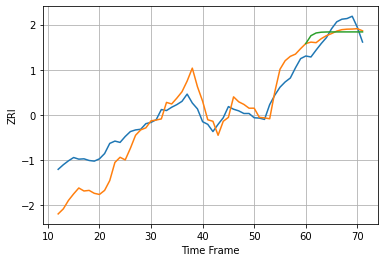

20024 64.16774766753092 28.89993217148299 38.11201650909486


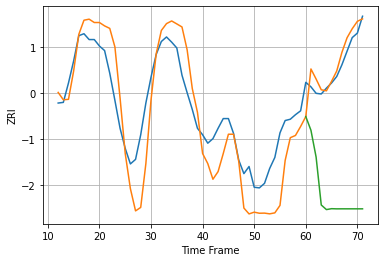

20037 50.61916002092695 21.4387265782238 204.4263967616387


In [14]:
time_train = list(range(SPLIT));
time_test = list(range(SPLIT, len(single_city_series)))

score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "RMSE_pure":[], "forecast":[]};

for zip_num in multi_1:
    test = multi_data[multi_data["zip"] == zip_num];
    city_mean = cities_stats[zip_num]["mean"];
    city_std = cities_stats[zip_num]["std"];
    
    single_city_series = (np.array(test["zri"]) - city_mean)/city_std;
    
    forecast = []
    results = []
    for time in range(len(single_city_series) - WINDOW_SIZE):
        forecast.append(model.predict(single_city_series[time:time + WINDOW_SIZE, np.newaxis, np.newaxis]))

    #print(forecast)

    # forecast = forecast[SPLIT - WINDOW_SIZE:]
    # print(np.array(forecast).shape)
    results = np.array(forecast)[:, -1, 0]
    actual = single_city_series[WINDOW_SIZE:]
    time_actual = range(WINDOW_SIZE, len(single_city_series));

    pure_forecast = list(single_city_series[SPLIT - WINDOW_SIZE: SPLIT]);
    for time in range(SPLIT, len(single_city_series)):
        # print(model.predict(pure_forecast[-WINDOW_SIZE:][np.newaxis]))
        pure_forecast.append(np.array(model.predict(np.array(pure_forecast[-WINDOW_SIZE:])[..., np.newaxis, np.newaxis]))[-1,0])
    pure_forecast = np.array(pure_forecast[WINDOW_SIZE:]);
    
    M_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * city_std;
    M_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * city_std;
    M_pure = mean_squared_error(actual[-TEST_LENGTH:], pure_forecast[-TEST_LENGTH:])**0.5 * city_std;
    forecast = list(np.array(pure_forecast[-TEST_LENGTH:]) * city_std + city_mean);
    
    plot_series(time_actual, actual);
    plot_series(time_actual, results);
    plot_series(time_test, pure_forecast);
    plt.show();
    
    score_dict["zip"].append(zip_num);
    score_dict["RMSE_train"].append(M_train);
    score_dict["RMSE_test"].append(M_test);
    score_dict["RMSE_pure"].append(M_pure);
    score_dict["forecast"].append(forecast);
    print(zip_num, M_train, M_test, M_pure)


In [15]:
print(len(score_dict["RMSE_pure"]), sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]),
      sum(score_dict["RMSE_pure"])/len(score_dict["RMSE_pure"]));

214 36.15719942612111 72.22027339983053


In [16]:
test = pd.DataFrame(score_dict)
test.to_csv('NN_1_batch.csv', index = False)

In [17]:
# NN_1_summary = pd.read_csv('./NN_1_summary.csv', index_col = 0);


In [18]:
# NN_1_summary[NN_1_summary.index.isin(score_dict["zip"])]["RMSE_pure"].mean()

### Then, we need to tune the hyperparameters...

#### Starting from here, we need a train/validation/test split

#### Wrapping to GridSearchCV in sklearn...

Plan: use the `tf.keras.wrappers.scikit_learn.KerasRegressor` wrapper

https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor

In [19]:
# model.save('saved_model/my_model')
# new_model = tf.keras.models.load_model('saved_model/my_model')